## Import All modules

In [1]:
# importing sys
import sys

# adding Folder_2 to the system path
sys.path.insert(0, '/home/jeongeun/faster_rcnn_rilab')

In [2]:
# AI2 THOR
!pkill thor_*
import ai2thor
from ai2thor.controller import Controller,BFSController
from ai2thor.platform import CloudRendering
from ithor_tools.vis_tool import *
from ithor_tools.transform import cornerpoint_projection,depth2world
from ithor_tools.map2 import single_scenemap
from ithor_tools.landmark_utils import gather,vis_panorama,Word_Dict,choose_ladmark
import random
import math
from IPython.display import display
from moviepy.editor import ImageSequenceClip,VideoFileClip

# Co occurance module
from co_occurance.comet_co import co_occurance_score
from co_occurance.move import co_occurance_based_schedular
from co_occurance.move import co_occurance_based_schedular

# Planning Module
from RRT import gridmaprrt as rrt
from RRT import gridmaprrt_pathsmoothing as smoothing
from IPython.display import Image as IM

In [3]:
# Detector module
from data.phase_1 import load_voc_instances,VOC_CLASS_NAMES
import torch
import cv2
import copy
import matplotlib.pyplot as plt
from engine.predictor import DefaultPredictor

from  config.config import get_cfg
from model.rcnn import GeneralizedRCNN
from detector.postprocess import postprocess,plot_openset,plot_candidate

## Matching Module
from detector.query_matching import matcher

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Setup AI2THOR

In [4]:
gridSize=0.05

controller = Controller(
    platform = CloudRendering,
    agentMode="locobot",
    visibilityDistance=5.0,
    scene = "FloorPlan_Train11_4",
    gridSize=gridSize,
    movementGaussianSigma=0,
    rotateStepDegrees=90,
    rotateGaussianSigma=0,
    renderDepthImage=False,
    renderInstanceSegmentation=False,
    width=300,
    height=300,
    fieldOfView=60
)

INFO - 2022-05-10 15:48:21,008 - controller - Initialize return: {'cameraNearPlane': 0.10000000149011612, 'cameraFarPlane': 20.0}


In [5]:
controller.reset(
    # makes the images a bit higher quality
    width=800,
    height=800,

    # Renders several new image modalities
    renderDepthImage=True,
    renderInstanceSegmentation=False,
    renderSemanticSegmentation=False,
    renderNormalsImage=False
)
scene_bounds = controller.last_event.metadata['sceneBounds']['center']
controller.step(
    action="AddThirdPartyCamera",
    position=dict(x=scene_bounds['x'], y=5.0, z=scene_bounds['z']),
    rotation=dict(x=90, y=0, z=0),
    orthographic=True,
    orthographicSize= 5.0, fieldOfView=100,
    skyboxColor="white"
)
controller.step(dict(action='GetReachablePositions'))
rstate = controller.last_event.metadata['actionReturn']

controller.step(
    action="Teleport",
    position = rstate[100]
)

pos = controller.last_event.metadata['agent']['position']
pos = [pos['x'],pos['z']]
objects = controller.last_event.metadata['objects']

In [6]:
df = show_objects_table(objects)
df

Object Metadata. Not showing objectOrientedBoundingBox, axisAlignedBoundingBox, and receptacleObjectIds for clarity.


objectType                            objectId  \
0             Box            Box|+01.32|+00.24|-02.71   
1          Statue         Statue|+09.25|+00.74|-02.78   
2      AlarmClock     AlarmClock|+01.28|+00.48|-04.63   
3          Bottle         Bottle|+08.37|+00.74|-03.32   
4          Laptop         Laptop|+01.71|+00.35|-01.61   
5       FloorLamp       FloorLamp|+04.23|00.00|-03.09   
6      BasketBall     BasketBall|+01.13|+00.12|-04.34   
7     BaseballBat    BaseballBat|+06.13|+00.68|-01.11   
8   RemoteControl  RemoteControl|+03.13|+00.40|-02.91   
9      SaltShaker     SaltShaker|+03.14|+00.40|-02.57   
10     HousePlant     HousePlant|+08.86|+00.74|-03.11   
11           Vase           Vase|+08.40|+00.74|-02.73   
12     Television     Television|+02.43|+00.89|-02.72   
13          Plate          Plate|+08.66|+00.74|-02.80   
14    SprayBottle     SprayBottle|+01.50|00.00|-04.76   
15     GarbageCan      GarbageCan|+03.67|00.00|-02.69   
16         Pillow         Pillow|+09.13|+00.37|-04.13   
17            Pot             Pot|+08.69|00.00|-02.75   
18       DeskLamp       DeskLamp|+09.47|+00.74|-03.14   
19   PepperShaker   PepperShaker|+02.97|+00.40|-02.93   
20            Cup            Cup|+01.77|+00.40|-02.92   
21          Apple          Apple|+06.14|+00.49|-03.08   
22    DiningTable    DiningTable|+09.01|+00.00|-03.00   
23       Painting       Painting|+06.82|+01.24|-04.90   
24       ArmChair       ArmChair|+01.62|+00.00|-01.54   
25       Painting       Painting|+07.16|+01.37|-01.01   
26            Mug            Mug|+06.32|+00.43|-03.17   
27       ArmChair        ArmChair|+05.53|00.00|-01.50   
28       Painting       Painting|+04.44|+01.32|-01.01   
29           Sofa            Sofa|+09.31|00.00|-01.80   
30    CoffeeTable    CoffeeTable|+02.43|+00.00|-02.78   
31      SideTable      SideTable|+01.23|+00.00|-04.66   
32          Floor          Floor|+00.00|+00.00|+00.00   
33       ArmChair       ArmChair|+09.24|+00.01|-04.10   
34           Bowl           Bowl|+05.46|+00.46|-01.63   
35          Chair          Chair|+06.26|+00.00|-03.22   

                                   name  position[x]  position[y]  \
0                                Box_12       1.3250       0.2405   
1                       Waving_Statue_2       9.2529       0.7415   
2                        Alarm_Clock_24       1.2835       0.4783   
3                              Bottle_1       8.3749       0.7416   
4                             Laptop_24       1.7096       0.3512   
5                         Floor_Lamp_21       4.2270      -0.0009   
6                          Basketball_1       1.1323       0.1200   
7                         BaseballBat_2       6.1274       0.6817   
8                              Remote_3       3.1321       0.4015   
9                         Salt_Shaker_2       3.1390       0.4002   
10                        Houseplant_24       8.8630       0.7431   
11                        Vase_Medium_4       8.3968       0.7427   
12                        Television_24       2.4332       0.8861   
13                              Plate_7       8.6618       0.7424   
14                       Spray_Bottle_6       1.5040      -0.0005   
15                               bin_24       3.6670      -0.0005   
16                            pillow_24       9.1315       0.3683   
17                               Pot_13       8.6890      -0.0002   
18                          Desk_Lamp_2       9.4702       0.7425   
19                      Pepper_Shaker_1       2.9674       0.4004   
20                               Cup_18       1.7807       0.3991   
21                             Apple_24       6.1388       0.4924   
22  thorkea_dining_table_norden_gateleg       9.0139       0.0014   
23                   Wall_Decor_Photo_4       6.8190       1.2420   
24              thorkea_armchair_emmabo       1.6230       0.0004   
25                   Wall_Decor_Photo_2       7.1610       1.3740   
26                                

## Make Object Query

In [7]:
landmarks,visible_landmark_name = choose_ladmark(objects)
landmark_cat = [Word_Dict[l] for l in visible_landmark_name]
# query_object = random.choice(objects)
query_object = objects[8] #20
query_object_name = query_object['objectType']

print(query_object_name)

RemoteControl


## Setup Co occurance

In [8]:
co_occurance_scoring = co_occurance_score(landmark_cat,'cuda:0')


model loading ...
model loaded


INFO - 2022-05-10 15:48:30,343 - utils - using task specific params for summarization: {'early_stopping': True, 'length_penalty': 2.0, 'max_length': 24, 'min_length': 1, 'no_repeat_ngram_size': 3, 'num_beams': 4}


0.6868000030517578 10.446799278259277 -5.351839542388916 0.5981607437133789
0
(418, 713, 4)


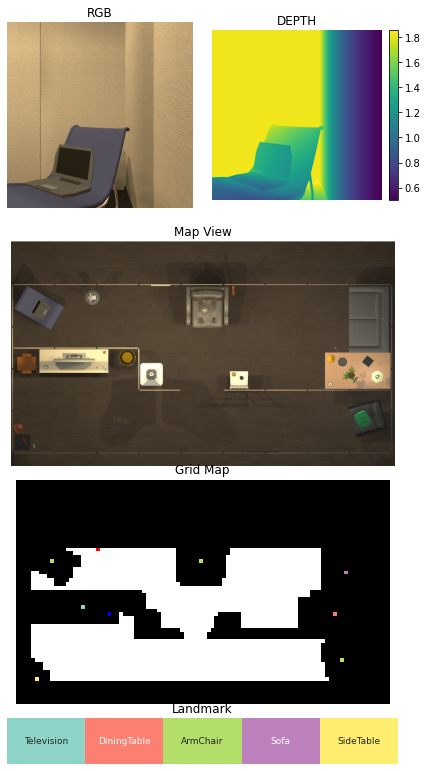

In [9]:
scene_bounds = controller.last_event.metadata['sceneBounds']['cornerPoints']
scene_bounds = cornerpoint_projection(scene_bounds)

sm = single_scenemap(scene_bounds,rstate,stepsize = 0.1,
                landmark_names=visible_landmark_name,landmarks=landmarks)
landmark_config = dict(name=visible_landmark_name,color = sm.landmark_colors)
imshow_grid = sm.plot(controller.last_event.metadata['agent']['position'],query_object['position'])
plot_frames(controller.last_event,imshow_grid,landmark_config)

## Setup Detector

In [10]:
'''
config file
'''

print(torch.cuda.device_count())
torch.cuda.set_device(0)
print(torch.cuda.current_device())
cfg = get_cfg()
cfg.merge_from_file('../faster_rcnn_rilab/config_files/voc.yaml')
cfg.MODEL.SAVE_IDX=19
cfg.MODEL.RPN.USE_MDN=False
cfg.log = False 
cfg.MODEL.ROI_HEADS.USE_MLN = True
cfg.MODEL.ROI_HEADS.AUTO_LABEL = False
cfg.MODEL.ROI_HEADS.AF = 'baseline'
cfg.MODEL.RPN.AUTO_LABEL = False
cfg.MODEL.ROI_BOX_HEAD.USE_FD = False
cfg.MODEL.RPN.AUTO_LABEL_TYPE = 'sum'
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 21
cfg.INPUT.RANDOM_FLIP = "none"
cfg.MODEL.ROI_HEADS.UNCT = True
cfg.PATH = '../faster_rcnn_rilab'

# cfg.merge_from_list(args.opts)
RPN_NAME = 'mdn' if cfg.MODEL.RPN.USE_MDN else 'base'
ROI_NAME = 'mln' if cfg.MODEL.ROI_HEADS.USE_MLN else 'base'
MODEL_NAME = RPN_NAME + ROI_NAME
# cfg.merge_from_list(args.opts)
cfg.freeze()
# wandb.init(config=cfg,tags= 'temp',name = 'temp',project='temp')

2
0


In [11]:
device = 'cuda:0'
model = GeneralizedRCNN(cfg,device = device).to(device)
state_dict = torch.load('../faster_rcnn_rilab/ckpt/{}/{}_{}_15000.pt'.format(cfg.MODEL.ROI_HEADS.AF,cfg.MODEL.SAVE_IDX,MODEL_NAME),map_location=device)
pretrained_dict = {k: v for k, v in state_dict.items() if k in model.state_dict()}
model.load_state_dict(pretrained_dict)

predictor = DefaultPredictor(cfg,model)

WARNING - 2022-05-10 15:48:31,235 - warnings - /home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:45: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.weight,std=0.01)

WARNING - 2022-05-10 15:48:31,276 - warnings - /home/jeongeun/faster_rcnn_rilab/model/rpn/rpn.py:46: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  nn.init.normal(layers.bias,0)



WARNING - 2022-05-10 15:48:31,964 - warnings - /home/jeongeun/.pyenv/versions/det/lib/python3.8/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



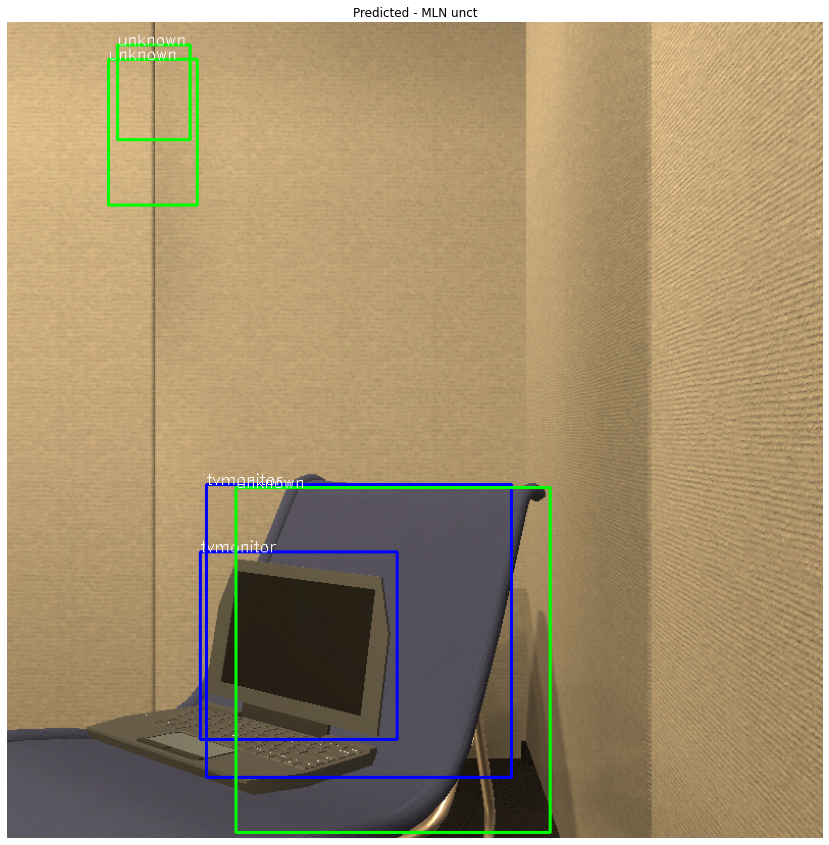

In [12]:
'''
Example of Openset Detection
'''
VOC_CLASS_NAMES = (
    "aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
    "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
    "pottedplant", "sheep", "sofa", "train", "tvmonitor", 'unknown'
)

img = controller.last_event.cv2img
pred = predictor(img)
pred_boxes, pred_classes = postprocess(pred)
plot_openset(img,pred_boxes,pred_classes,VOC_CLASS_NAMES)

In [13]:
'''
Load Matcher
'''
query_matcher = matcher(query_object_name,threshold=28,device = device)

## Co-occurance Score

In [14]:
thres = 0.3
res = co_occurance_scoring.score(query_object_name)
res

a photo of a remote control


In [15]:
schedular = co_occurance_based_schedular(landmarks,visible_landmark_name)
schedular.get_graph(sm,controller,res,thres)

path = schedular.optimize()
vis_visit_landmark(query_object,path,controller,sm,landmark_config)

[1.0, 0.587, 0.279, 1.0, 0.67]

[0, 1, 3, 2, 4]


## Move To landmark

In [16]:
rrtplanner = rrt.RRT(controller = controller, expand_dis=0.1,max_iter=10000,goal_sample_rate=20)
d2w = depth2world()


In [17]:
'''
Move to inital position
'''
controller.step(
    action="Teleport",
    position = rstate[100]
)

<ai2thor.server.Event at 0x7fecb1ca3370
    .metadata["lastAction"] = Teleport
    .metadata["lastActionSuccess"] = True
    .metadata["errorMessage"] = "
    .metadata["actionReturn"] = None
>

In [18]:
def detect(frames,single_pos,controller,predictor,matcher):
    patch = []
    map_p = []
    for frame,pos in zip(frames,single_pos):
        pred = predictor(frame)
        pred_boxes, _ = postprocess(pred)
        plot_openset(frame,pred_boxes,pred_classes,VOC_CLASS_NAMES)
        show_patch,candidate_boxes = matcher.matching_score(frame,pred_boxes)
        DEPTH = controller.last_event.depth_frame
        COLOR = controller.last_event.frame.astype(np.uint8)
        map_points = d2w.object_coord(candidate_boxes,DEPTH,COLOR
                            ,pos['pos'],pos['rot'])
        patch.append(show_patch)
        map_p += map_points
    return np.concatenate(patch,axis=0),map_p

[{'x': 2.4000000000000004, 'y': 0.91, 'z': -3.8000000000000007}, 0, 1.0]
start planning
path found!
end planning


(418, 713, 4)


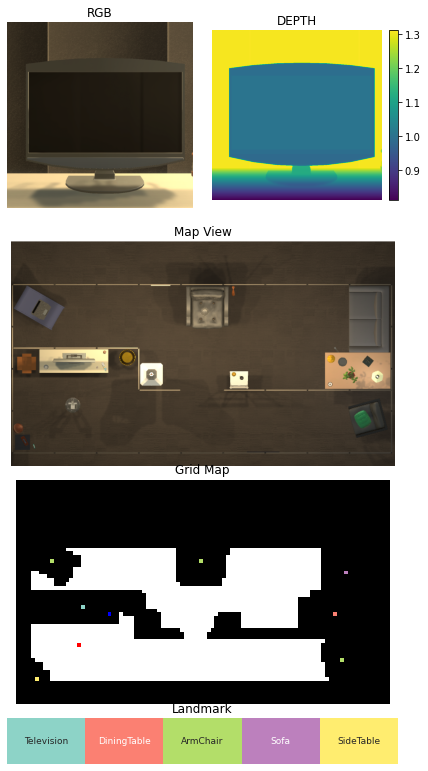

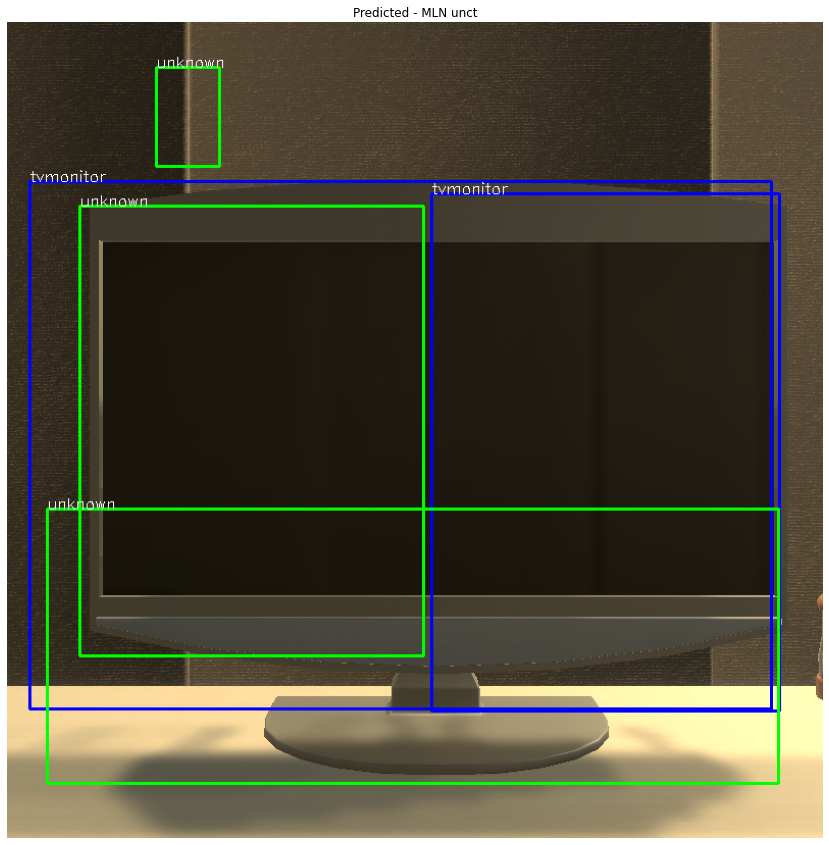

tensor([[29.2500, 26.0312, 27.9844, 28.6719, 26.6562]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward>)


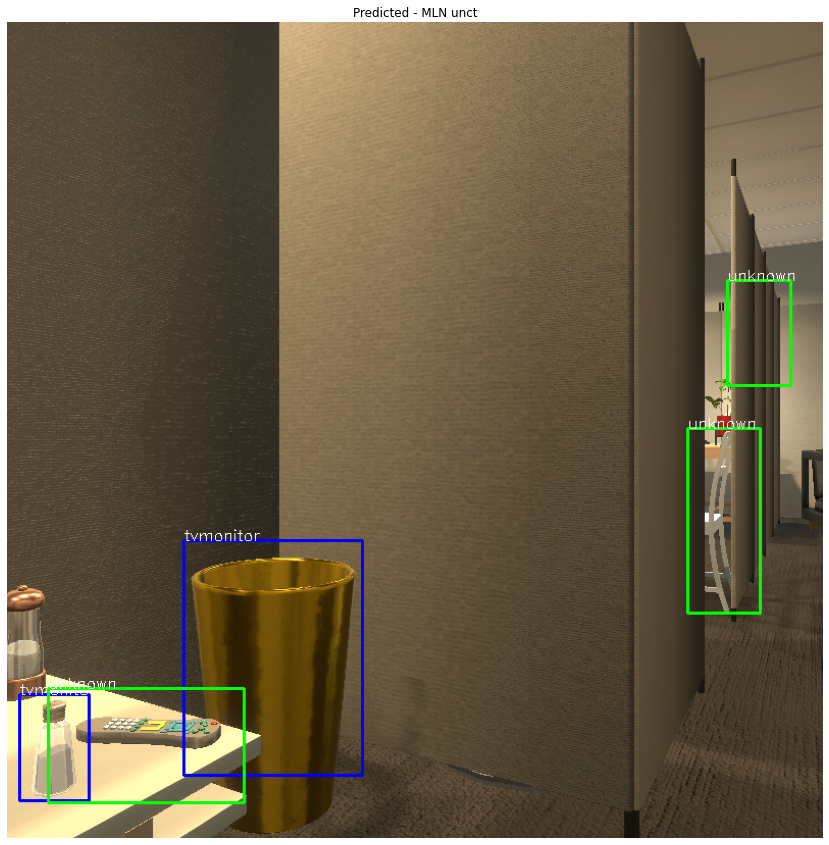

tensor([[20.3438, 22.5000, 26.5781, 24.5312, 28.8281, 22.8125, 26.1875]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)


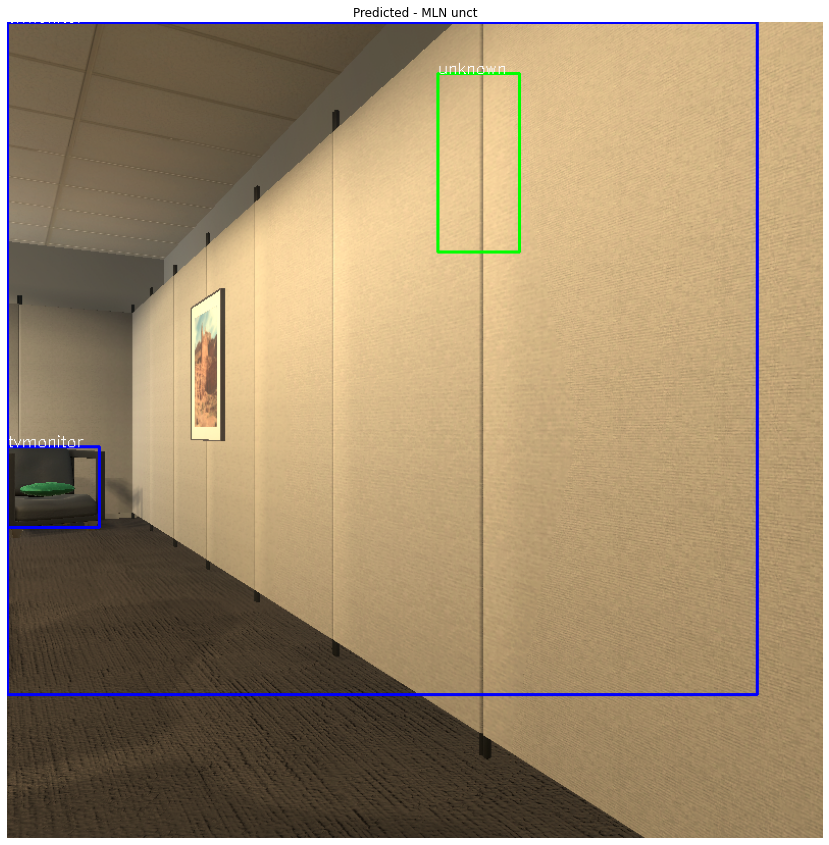

tensor([[25.2656, 22.7188, 28.1719]], device='cuda:0', dtype=torch.float16,
       grad_fn=<MmBackward>)


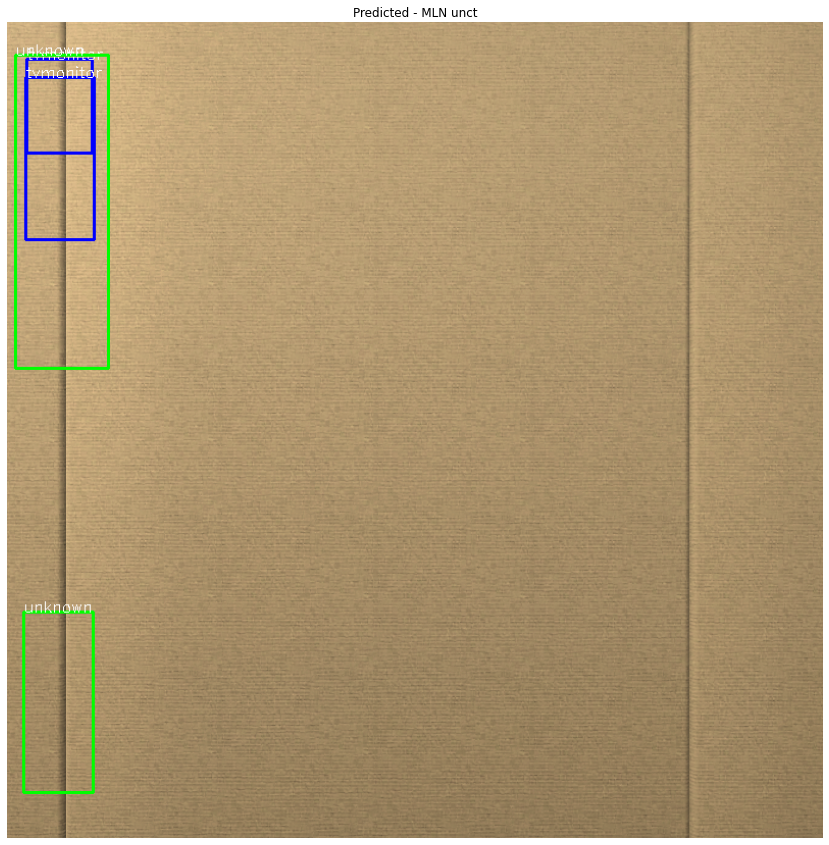

tensor([[24.6094, 26.1250, 26.2500, 27.6406]], device='cuda:0',
       dtype=torch.float16, grad_fn=<MmBackward>)


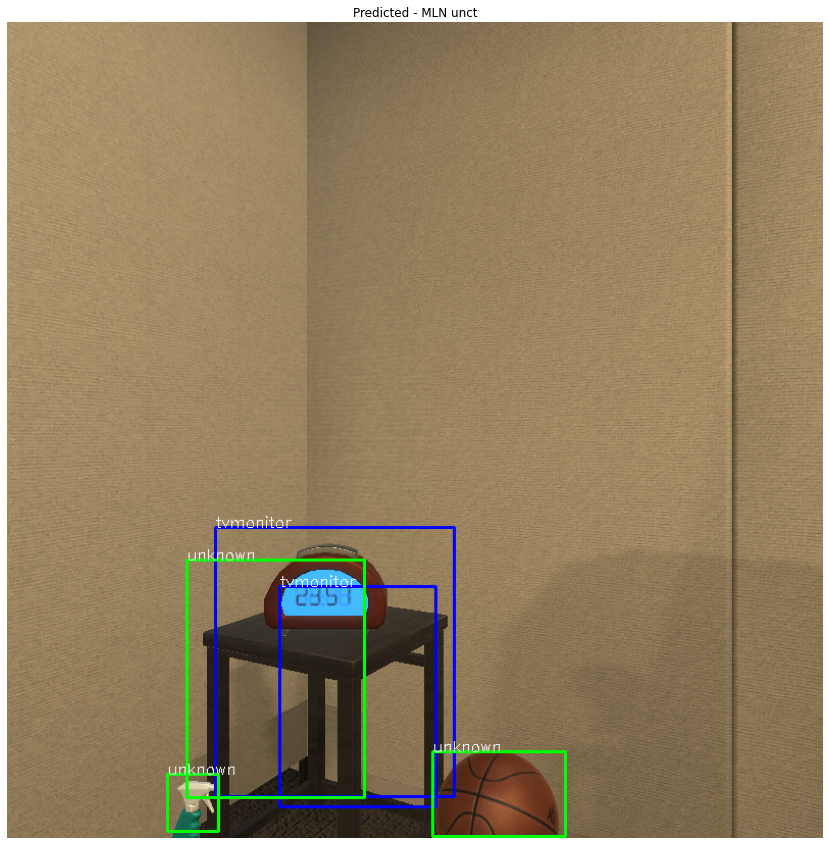

tensor([[23.8281, 26.8594, 22.8750, 25.0156, 22.1562, 24.0000, 22.0781, 26.7344]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)


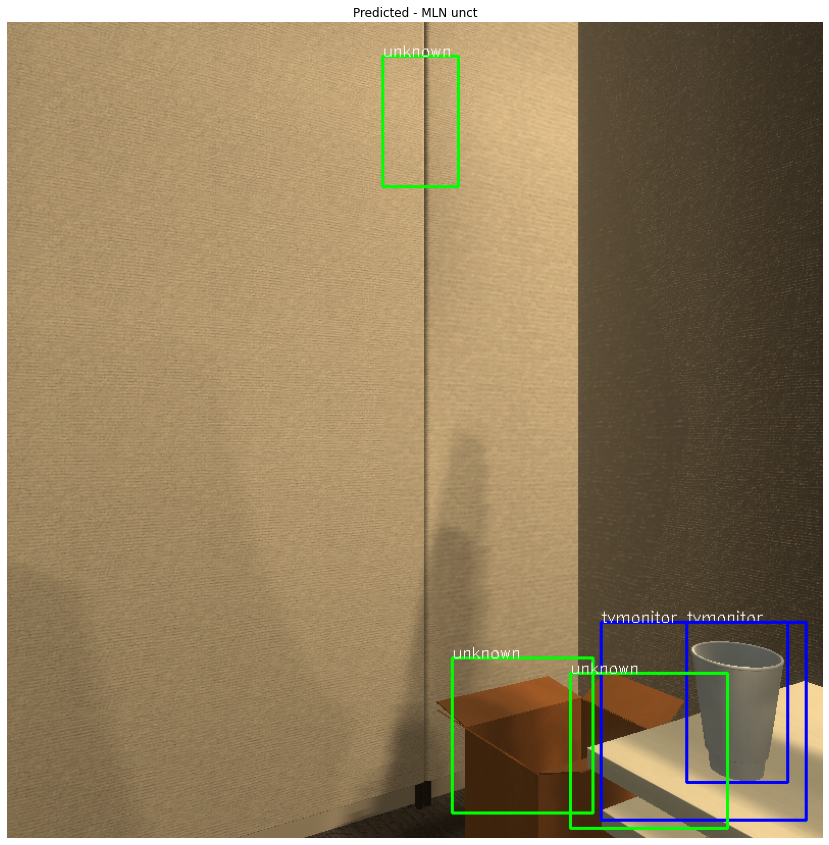

tensor([[22.4375, 22.0625, 24.2812, 26.4219, 23.4531, 22.5625]],
       device='cuda:0', dtype=torch.float16, grad_fn=<MmBackward>)


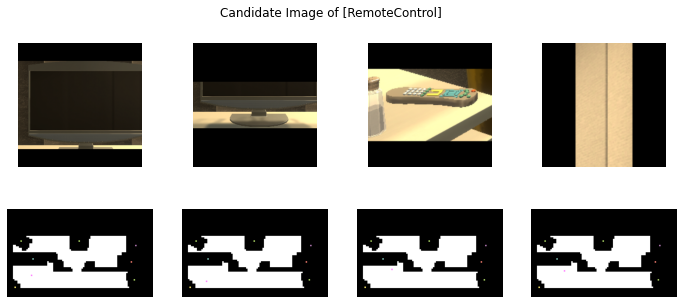

In [19]:
for p in path[1:]:
    print(p)
    pos = controller.last_event.metadata['agent']['position']
    rrtplanner.set_start(pos)
    rrtplanner.set_goal(p[0])
    print("start planning")
    local_path = rrtplanner.planning(animation=False)
    smoothpath = smoothing.path_smoothing(rrtplanner,40,verbose=False)
    print("end planning")
    rrtplanner.plot_path(smoothpath)
    
    flag,frames = rrtplanner.go_with_teleport(smoothpath,maxspeed=0.2)
    # video = ImageSequenceClip(frames, fps=10)
    # video.write_gif('temp.gif')
    # with open('temp.gif','rb') as file:
    #     display(IM(file.read(),width = 300))
    
    pos = controller.last_event.metadata['agent']['position']
    controller.step(
        action="Teleport",
        position = pos, rotation = dict(x=0,y=p[1],z=0)
            )
    imshow_grid = sm.plot(pos,query_object['position'])
    plot_frames(controller.last_event,imshow_grid,landmark_config)
    frames, single_pos,gt_vis = gather(controller,query_object['objectType'],step=6)
    candidate_patches, candidate_map_points = detect(frames,single_pos,controller,predictor,query_matcher)
    # vis_panorama(frames)
    if len(candidate_patches):
        plot_candidate(candidate_patches,candidate_map_points,query_object_name,sm)
        break